# Generative Adverserial Networks

## Prerequisites

This section helps in getting the dataset from Kaggle. The dataset is available at the following link: 

https://www.kaggle.com/puneet6060/intel-image-classification

Get your own `kaggle.json` file using the following steps:

1. Sign in to your Kaggle account.
2. Go to **Account**, go to the **API** section.
3. Click on **Create New API Token** button.
4. The `kaggle.json` file is downloaded.
5. Initialize the runtime in this notebook, go to the **Flies** section on the left side of the notebook.
6. Right click and click on **Upload**, select the `kaggle.json` file and upload it.

Once that is done, run the following section to import the dataset.

NOTE: A sample `kaggle.json` file is provided to supplement this code. 

**IMPORTANT: The `kaggle.json` file has to be uploaded every single time the runtime is restarted or recycled if the program is being executed on a platform like Google Colab. Not doing so will result in failure to load the dataset.**

In [ ]:
pip install kaggle

In [ ]:
mkdir ~/.kaggle

In [ ]:
cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install git+https://github.com/google-research/tf-slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google-research/tf-slim to /tmp/pip-req-build-pfwcrrbm
  Running command git clone -q https://github.com/google-research/tf-slim /tmp/pip-req-build-pfwcrrbm
  Created wheel for tf-slim: filename=tf_slim-1.2.0-py3-none-any.whl size=360964 sha256=fa3c39fda072a098a6accd4a4c5da8085ab3ff06fa2145a2c4735ebe0027a648
  Stored in directory: /tmp/pip-ephem-wheel-cache-ht481g9q/wheels/f4/84/2f/c5140718a49612b5ff335b62bb132d3020e9f7f307bcb3531a
Successfully built tf-slim


In [ ]:
!kaggle datasets download puneet6060/intel-image-classification

100% 345M/346M [00:04<00:00, 69.4MB/s]
100% 346M/346M [00:04<00:00, 78.1MB/s]


In [ ]:
mkdir intel_images

In [ ]:
!unzip intel-image-classification.zip -d intel_images

Streaming output truncated to the last 5000 lines.
  inflating: intel_images/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/767.jpg  
  inflating: intel_images/

In [ ]:
%matplotlib inline

## GAN Code


### Import Packages

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from PIL import Image

In [ ]:
dataroot = "/content/intel_images/seg_train/seg_train"
batch_size = 64
image_size = 64
num_epochs = 200
ngpu = 1

### Loading Data

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
resize = transforms.Resize((image_size, image_size))
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               resize,
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

building_set = Subset(dataset, range(0, 2192))
forest_set = Subset(dataset, range(2192, 4462))
glacier_set = Subset(dataset, range(4462, 6866))
mountain_set = Subset(dataset, range(6866, 9378))
sea_set = Subset(dataset, range(9378, 11652))
street_set = Subset(dataset, range(11652, 14034))

Uncomment a different line to train a different subset.

In [ ]:
# Create the dataloader
# train_dataloader = DataLoader(building_set, batch_size=batch_size, shuffle=True)
# train_dataloader = DataLoader(forest_set, batch_size=batch_size, shuffle=True)
# train_dataloader = DataLoader(glacier_set, batch_size=batch_size, shuffle=True)
# train_dataloader = DataLoader(mountain_set, batch_size=batch_size, shuffle=True)
# train_dataloader = DataLoader(sea_set, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(street_set, batch_size=batch_size, shuffle=True)

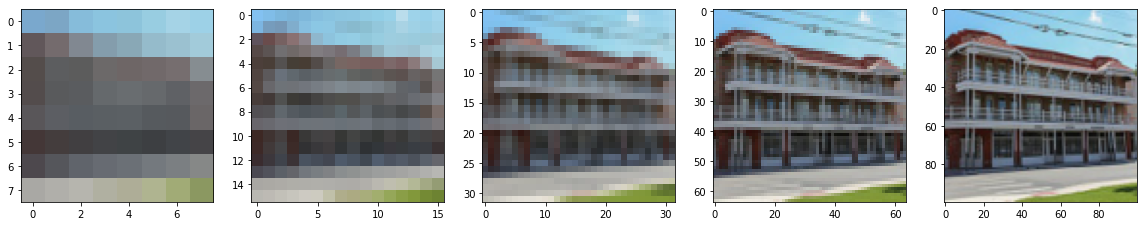

In [ ]:
fig, axes = plt.subplots(1, 5, figsize = (20, 10))
img = dataroot + '/buildings' + "/1001.jpg"
img = Image.open(img)
resized_img = [transforms.Resize(size = size)(img) for size in [8, 16, 32, 64, 100]]
for i in range(len(axes)):
    axes[i].imshow(resized_img[i])
plt.show()

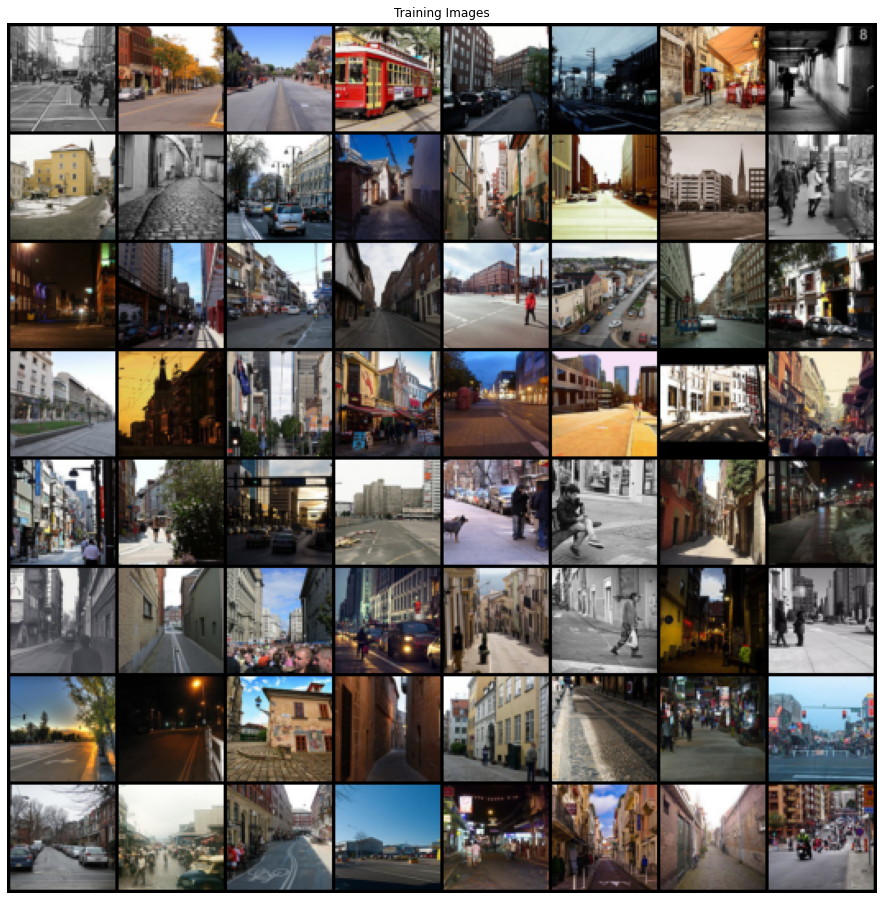

In [ ]:
# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize = (16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### Initialize weights

In [ ]:
# Weights initialization called on gen_obj and dis_obj
def initialize_GAN_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator Class



In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d( 100, 64*8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( 64*4, 64*2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias = False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
gen_obj = Generator(ngpu).to(device)

gen_obj.apply(initialize_GAN_weights)
print(gen_obj)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


 ### Discriminator Class


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(3, 64, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 64*2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64*2, 64*4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64*4, 64*8, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64*8, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
dis_obj = Discriminator(ngpu).to(device)

dis_obj.apply(initialize_GAN_weights)
print(dis_obj)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Training


In [ ]:
fixed_noise = torch.randn(image_size, 100, 1, 1, device=device)
lr = 0.0002
dis_opt = optim.Adam(dis_obj.parameters(), lr=lr, betas=(0.5, 0.999))
gan_opt = optim.Adam(gen_obj.parameters(), lr=lr, betas=(0.5, 0.999))

losses_list = [[], []]

criterion = nn.BCELoss()
for epoch in range(num_epochs):
    g_l, d_l = 0, 0
    for i, data in enumerate(train_dataloader, 0):

        dis_obj.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output = dis_obj(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = gen_obj(noise)
        label.fill_(0)
        output = dis_obj(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        dis_opt.step()

        gen_obj.zero_grad()
        label.fill_(1)
        output = dis_obj(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        gan_opt.step()
        g_l = errG.item()
        d_l = errD.item()
 
        losses_list[0].append(errG.item())
        losses_list[1].append(errD.item())
        if i % 50 == 0:
            print(f"Epoch: {epoch:03}/{num_epochs}:\n\tGenerator Loss: {g_l:08.5f}\tDiscriminator Loss: {d_l:08.5f}")        

### Results

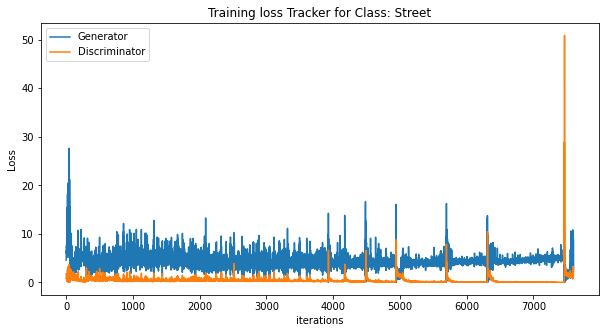

In [ ]:
plt.figure(figsize = (10,5))
plt.title("Training loss Tracker for Class: Street")
plt.plot(losses_list[0], label="Generator")
plt.plot(losses_list[1], label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("streets_200_epochs.png")
plt.show()

### Save the models

In [ ]:
torch.save(gen_obj, "/content/streets/streets_gen.pt")
torch.save(dis_obj.state_dict(), "/content/streets/streets_dis.pt")

### Generate and Save images

In [ ]:
lst = []
temp = torch.randn(1000, 100, 1, 1, device=device)
with torch.no_grad():
    fake = gen_obj(temp).detach().cpu()
lst.append(vutils.make_grid(fake, padding=2, normalize=True))

In [ ]:
# plt.subplot(1,2,2)
from torchvision.utils import save_image
for i in range(len(fake)):
    save_image(fake[i], "streets/streets" + str(i).zfill(4) + ".png")

In [ ]:
!zip -r /content/generated_data.zip /content/streets

## Resources

The following resources came very handy in the construction of this code.


[Original GAN Paper](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf)

[DC-GAN Paper](https://arxiv.org/pdf/1511.06434.pdf)

[DC-GAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

[PyTorch GAN Tutorial](https://learnopencv.com/deep-convolutional-gan-in-pytorch-and-tensorflow/)